# LIDC-IDRI Lung Segmentation


In [1]:
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [2]:
import cv2
import keras
import datasets
import numpy as np
import tensorflow as tf
import albumentations as A
import matplotlib.pyplot as plt
import segmentation_models as sm

sm.set_framework("tf.keras")
sm.framework()

from PIL import Image
from dataclasses import dataclass
from keras.metrics import Accuracy, Recall, Precision, AUC

from segmentation_models import Unet, get_preprocessing
from segmentation_models.losses import bce_dice_loss
from segmentation_models.metrics import iou_score

/Users/jmanuelc87/Documents/Proyectos/lung-segmentation-lidc-idri/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Segmentation Models: using `tf.keras` framework.


Load the dataset


In [3]:
lung_dataset = datasets.load_dataset("jmanuelc87/lidc-idri-segmentation")
lung_dataset = lung_dataset["train"].train_test_split(train_size=0.8, seed=42)  # type: ignore
lung_dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'image_mask', 'patch', 'patch_mask', 'malignancy', 'cancer'],
        num_rows: 2120
    })
    test: Dataset({
        features: ['image', 'image_mask', 'patch', 'patch_mask', 'malignancy', 'cancer'],
        num_rows: 531
    })
})

## Configuration


In [ ]:
@dataclass
class TrainingConfig:
    EPOCHS: int = 200
    NUM_CLASSES: int = 1
    BATCH_SIZE: int = 32
    IMG_WIDTH: int = 224
    IMG_HEIGHT: int = 224

## Visualization

Exploration of some samples of the dataset and its masks


In [5]:
def num_to_rgb(mask):
    num_arr = np.array(mask)
    output = np.zeros(num_arr.shape[:2] + (3,))
    output[num_arr == 255] = (255, 0, 0)
    return output.astype(np.uint8)

In [6]:
def image_overlay(image, segmented_image):
    alpha = 1.0  # Transparency for the original image.
    beta = 0.7  # Transparency for the segmentation map.
    gamma = 0.0  # Scalar added to each sum.

    segmented_image = cv2.cvtColor(segmented_image, cv2.COLOR_RGB2BGR)

    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    image = cv2.addWeighted(image, alpha, segmented_image, beta, gamma, image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    return image

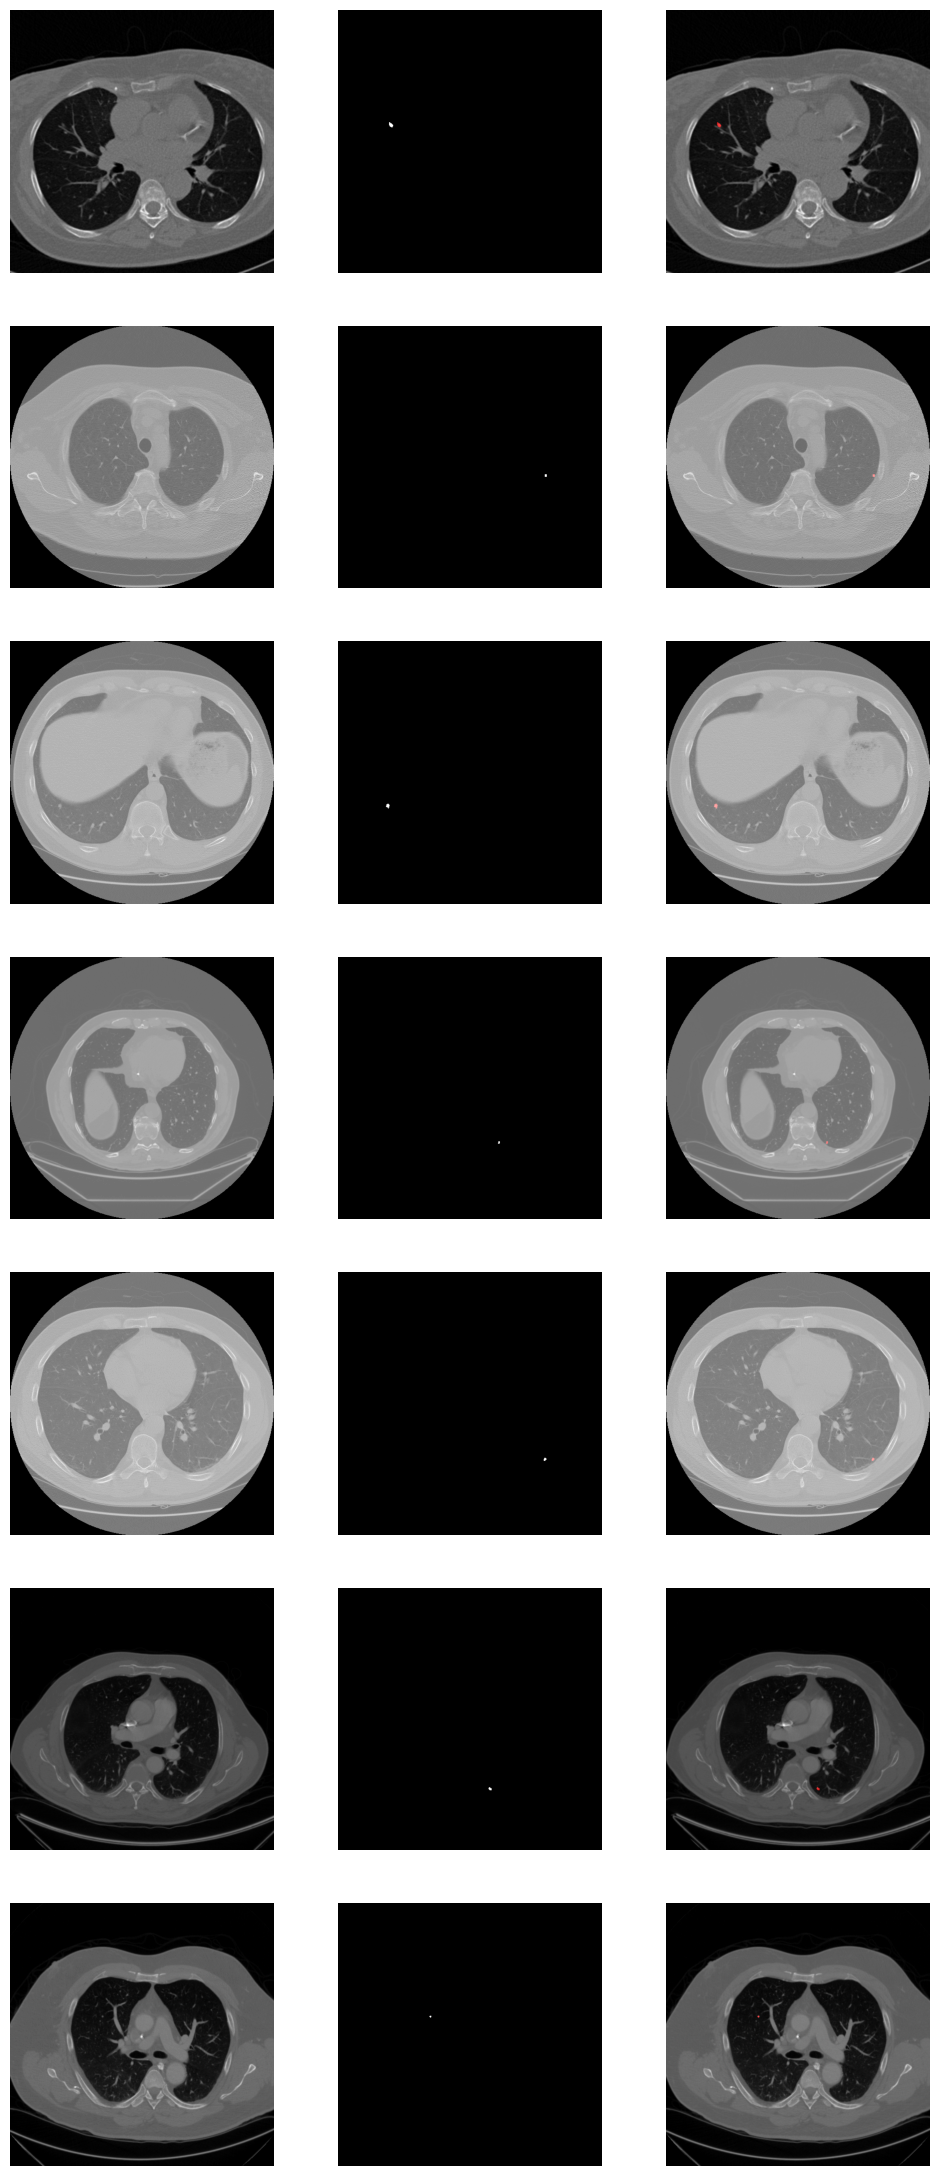

In [7]:
def plot(dataset: datasets.Dataset, qty=10):
    fig, ax = plt.subplots(qty, 3, figsize=(12, 28))

    for i, item in enumerate(dataset):
        if i >= qty:
            break

        ax[i, 0].axis("off")
        ax[i, 0].imshow(item["image"], cmap="gray")  # type: ignore

        ax[i, 1].axis("off")
        ax[i, 1].imshow(item["image_mask"], cmap="gray")  # type: ignore

        patch = np.array(item["image"])  # type: ignore
        patch = np.transpose(np.stack([patch, patch, patch]), axes=(1, 2, 0))

        mask = num_to_rgb(item["image_mask"])  # type: ignore
        image = image_overlay(patch, mask)

        ax[i, 2].axis("off")
        ax[i, 2].imshow(image, cmap="gray")


plot(lung_dataset["train"], qty=7)  # type: ignore

## Data Preparation

Preparation of the dataset using albumentations library for augmenting the dataset samples using the transformations:

- RandomCrop
- CenterCrop
- SquareSymmetry
- GaussNoise
- Normalize
- ToTensor

And creation of the train, valid and test splits for datasets and dataloaders


In [8]:
train_transforms = A.Compose(
    [
        A.Resize(
            height=TrainingConfig.IMG_HEIGHT,
            width=TrainingConfig.IMG_WIDTH,
            interpolation=cv2.INTER_NEAREST,
            p=1.0,
        ),
        A.Normalize(
            mean=(0.0, 0.0, 0.0),
            std=(1.0, 1.0, 1.0),
            max_pixel_value=255.0,
            p=1.0,
        ),
    ]
)


valid_transforms = A.Compose(
    [
        A.Resize(
            height=TrainingConfig.IMG_HEIGHT,
            width=TrainingConfig.IMG_WIDTH,
            p=1.0,
        ),
        A.Normalize(
            mean=(0.0, 0.0, 0.0),
            std=(1.0, 1.0, 1.0),
            max_pixel_value=255.0,
            p=1.0,
        ),
    ]
)

In [9]:
def map_image_transforms(transformations):

    def wrapper(row):
        augmented = []
        keys = row.keys()
        for item in zip(*row.values()):
            items = {k: np.array(v) for k, v in zip(keys, item)}
            values = transformations(**items)
            augmented.append(values)

        for key in keys:
            row[key] = [
                np.transpose(
                    np.stack([item[key], item[key], item[key]]).astype(np.float32),
                    axes=(1, 2, 0),
                )
                for item in augmented
            ]
        return row

    return wrapper

In [10]:
# Remove the columns not needed and rename the ones needed to be interpreted by albumentations library
new_lung_dataset = (
    lung_dataset.remove_columns(["patch", "patch_mask", "malignancy", "cancer"])
    .rename_column("image_mask", "mask")
)

In [11]:
def create_datasets(lung_dataset):
    lung_train_dataset = (
        lung_dataset["train"]
        .with_format("tensorflow")
        .with_transform(map_image_transforms(train_transforms))
        .to_tf_dataset(
            columns="image",
            label_cols="mask",
            batch_size=TrainingConfig.BATCH_SIZE,
        )
    )

    tmp_dataset = lung_dataset["test"].train_test_split(train_size=0.5)

    lung_valid_dataset = (
        tmp_dataset["train"]
        .with_format("tensorflow")
        .with_transform(map_image_transforms(valid_transforms))
        .to_tf_dataset(
            columns="image",
            label_cols="mask",
            batch_size=TrainingConfig.BATCH_SIZE,
        )
    )

    lung_test_dataset = (
        tmp_dataset["test"]
        .with_format("tensorflow")
        .with_transform(map_image_transforms(valid_transforms))
        .to_tf_dataset(
            columns="image",
            label_cols="mask",
            batch_size=TrainingConfig.BATCH_SIZE,
        )
    )

    return lung_train_dataset, lung_valid_dataset, lung_test_dataset

In [12]:
(
    train_dataset,
    valid_dataset,
    test_dataset,
) = create_datasets(new_lung_dataset)

2025-08-31 19:01:08.642515: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-08-31 19:01:08.642544: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-08-31 19:01:08.642551: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2025-08-31 19:01:08.642565: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-08-31 19:01:08.642574: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Modeling

Creation of a UNet model in pytorch


In [13]:
def dice_coef(y_true, y_pred):
    axes = (0, 1, 2)
    inter = tf.reduce_sum(y_true * y_pred, axis=axes)
    denom = tf.reduce_sum(y_true + y_pred, axis=axes)
    dice = tf.math.divide_no_nan(2.0 * inter, denom)
    mean = tf.reduce_mean(dice)
    return mean

In [14]:
model = Unet(
    backbone_name="resnet50",
    classes=1,
    activation="sigmoid",
)

model.compile(
    loss=bce_dice_loss,
    optimizer="adam",
    metrics=[iou_score, dice_coef],
)

In [ ]:
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss", mode="min", patience=6, restore_best_weights=True, verbose=1
)

history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=TrainingConfig.EPOCHS,
    batch_size=TrainingConfig.BATCH_SIZE,
    callbacks=[early_stop],
)

Epoch 1/3


2025-08-31 19:01:13.515603: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


 4/67 ━━━━━━━━━━━━━━━━━━━━ 5:43 5s/step - dice_coef: 0.1783 - iou_score: 0.0984 - loss: 1.3846

In [ ]:
def plot_results(metrics, ylabel=None, ylim=None, metric_name=None, color=None):
    from matplotlib.ticker import MultipleLocator, FormatStrFormatter

    fig, ax = plt.subplots(figsize=(18, 5))

    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [
            metrics,
        ]
        metric_name = [
            metric_name,
        ]

    for idx, metric in enumerate(metrics):
        ax.plot(metric, color=color[idx])  # type:ignore

    plt.xlabel("Epoch")
    plt.ylabel(ylabel)  # type:ignore
    plt.title(ylabel)  # type:ignore
    plt.xlim([0, TrainingConfig.EPOCHS - 1])
    plt.ylim(ylim)
    # Tailor x-axis tick marks
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_major_formatter(FormatStrFormatter("%d"))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(True)
    plt.legend(metric_name)
    plt.show(block=True)
    plt.close()

In [ ]:
train_acc = history.history["accuracy"]
valid_acc = history.history["val_accuracy"]

# Dice coefficient.
train_loss = history.history["loss"]
valid_loss = history.history["val_loss"]


plot_results(
    [train_acc, valid_acc],
    ylabel="Pixel Accuracy (Keras)",
    ylim=[0.0, 1.0],
    metric_name=["Training Accuracy", "Validation Accuracy"],
    color=["g", "b"],
)

plot_results(
    [train_loss, valid_loss],
    ylabel="Loss",
    ylim=[0.0, 500.0],
    metric_name=["Training Loss", "Validation Loss"],
    color=["g", "b"],
)

In [ ]:
def inference(model, dataset):

    num_batches_to_process = 1
    tf.experimental.numpy.experimental_enable_numpy_behavior()

    for idx, data in enumerate(dataset):

        if idx == num_batches_to_process:
            break

        batch_img, batch_mask = data[0], data[1]
        pred_all = (model.predict(batch_img)).astype("float32")
        pred_all = pred_all.argmax(-1)
        batch_img = (batch_img * 255).astype("uint8")

        for i in range(0, len(batch_img)):

            fig = plt.figure(figsize=(20, 8))

            # Display the original image.
            ax1 = fig.add_subplot(1, 4, 1)
            ax1.imshow(batch_img[i], cmap="gray")
            ax1.title.set_text("Actual frame")
            plt.axis("off")

            # Display the ground truth mask.
            true_mask = batch_mask[i]
            ax2 = fig.add_subplot(1, 4, 2)
            ax2.set_title("Ground truth labels")
            ax2.imshow(true_mask, cmap="gray")
            plt.axis("off")

            # Display the predicted segmentation mask.
            pred_mask = pred_all[i][:, :, np.newaxis]

            print(pred_mask.shape)

            ax3 = fig.add_subplot(1, 4, 3)
            ax3.set_title("Predicted labels")
            ax3.imshow(pred_mask, cmap="gray")
            plt.axis("off")

            plt.show()

In [ ]:
inference(model, test_dataset)